Los tipos de prendas de vestir son: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', y 'Ankle boot'. Que en las etiquetas de las imágenes se representan con números enteros de 0 a 9, respectivamente.



In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
#Graficos
import matplotlib.pyplot as plt
import seaborn as sns
# Métricas
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

El objetivo es transferir los pesos exclusivamente de las capas convolucionales y reestructurar la capa completamente conectada (según criterio del estudiante). Para las capas convolucionales realizar diferentes pruebas con respecto a si las capas se dejan entrenables o no entrenables hasta obtener resultados satisfactorios.


**Nota:** Primero me dedique a experimentar las diferentes ramas para comprender a fondo su funcionamiento, para al final poder unir esta *arquitectura*

#Carga dataset

In [ ]:
#Funcion para carga el dataset
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels


In [ ]:
X_train, y_train = load_mnist('/content/drive/MyDrive/fashion', kind='train')
X_test, y_test = load_mnist('/content/drive/MyDrive/fashion', kind='t10k')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

# 1. Transfer Learning


In [ ]:
#Funcion para carga el dataset
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels


In [ ]:

X_train, y_train = load_mnist('/content/drive/MyDrive/fashion', kind='train')
X_test, y_test = load_mnist('/content/drive/MyDrive/fashion', kind='t10k')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

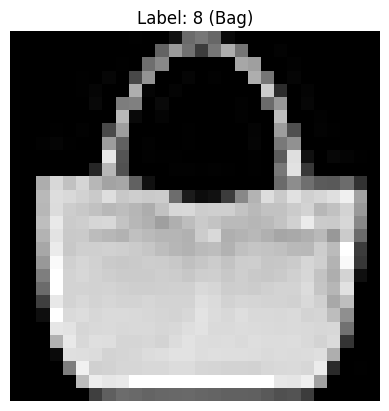

In [ ]:


##Codigo solo para ver ejemplos de las imagenes del dataset
image_index = 100
image = X_train[image_index].reshape(28, 28)
label = y_train[image_index]


class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


plt.imshow(image, cmap='gray')
plt.title(f"Label: {label} ({class_names[label]})")
plt.axis('off')
plt.show()

In [ ]:
# Aumento de dimensión para usar con modelos de CNN 2D
train_images = X_train.reshape(60000, 28, 28, 1)
test_images = X_test.reshape(10000, 28, 28, 1)
train_images.shape, test_images.shape



((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
# Usaremos 10.000 imágenes para explorar el TL
data_tl = test_images.copy()
data_tl.shape

(10000, 28, 28, 1)

In [ ]:
# Función para cambiar el tamaño de 28x28 a 224x224 para usarlas en TL enResnet
def cambiar_tamaño_imagenes(dataset,ancho,alto):
  imgs = list()
  for i in range(dataset.shape[0]):
    img = cv2.resize(dataset[i,:,:,0],dsize=(ancho,alto))
    imgs.append(img)
  imgs = np.array(imgs)
  return imgs

data_tl_224 = cambiar_tamaño_imagenes(data_tl,224,224)
data_tl_224.shape

(10000, 224, 224)

In [ ]:
# Aumentar dimensión para usar en la CNN
data_tl_224 = data_tl_224.reshape(data_tl_224.shape[0], 224, 224, 1)
data_tl_224.shape

(10000, 224, 224, 1)

##Generacion del modelo de Transfer Learning

In [ ]:

# ---------------------------------------
# FUNCIÓN PARA CONSTRUIR EL MODELO
# ---------------------------------------
def build_mobilenet_model(trainable_convs=False, num_classes=10):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Congelar todas las capas convolucionales para evitar reentrenamiento
    for layer in base_model.layers:
        layer.trainable = False

    # Descongelar las últimas capas para fine-tuning
    if trainable_convs:
        for layer in base_model.layers[-30:]:  # últimas 30 capas
            layer.trainable = True

    # Nueva cabeza (Fully Connected)
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256,activation='relu')(x)
    #Elimina el 50% de las neuronas para evitar overfitting
    x = layers.Dropout(0.5)(x)
    #Capa de salida para 10 clases
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ---------------------------------
# PREPROCESAR LOS DATOS con tf.data
# ---------------------------------
# One-hot encode primero
num_classes = 10
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Crear datasets SIN reshape previo (X_train y X_test deben ser (num_samples, 28, 28))
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_one_hot))

# Función de preprocesamiento Transforma imágenes MNIST (28x28, escala de grises) al formato que espera MobileNetV2
def preprocess_image(image, label):
    # Reshape si está aplanada (784,) -> (28, 28)
    image = tf.reshape(image, (28, 28))
    # Expandir a (28, 28, 1)
    image = tf.expand_dims(image, -1)
    # Convertir a RGB (28, 28, 3)
    image = tf.image.grayscale_to_rgb(image)
    # Redimensionar a (224, 224, 3)
    image = tf.image.resize(image, (224, 224))
    # Normalización de MobileNetV2
    image = preprocess_input(image)
    return image, label

#Tamaño del conjunto de datos
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Aplicar preprocesamiento a los datasets
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# ---------------------------------------
# ENTRENAR MODELO
# ---------------------------------------
model_finetune = build_mobilenet_model(trainable_convs=True, num_classes=num_classes)

# Callback: reducir LR si se estanca, el learning rate controla el ajuste de los pesos en cada iteracin, es bajito por el fine tunning
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1
)

print("\nEntrenando modelo (fine-tuning)...")
history_finetune = model_finetune.fit(train_dataset, epochs=10, verbose=1, callbacks=[lr_scheduler])

# ---------------------------------------
# GRAFICAR CURVAS
# ---------------------------------------
def plot_training_curves(history, label="Fine-tuning"):
    plt.figure(figsize=(14,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label=label, linestyle='--')
    plt.title('Precisión (Entrenamiento)')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label=label, linestyle='--')
    plt.title('Pérdida (Entrenamiento)')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_training_curves(history_finetune)

# ---------------------------------------
# EVALUAR MODELO
# ---------------------------------------
test_loss_ft, test_acc_ft = model_finetune.evaluate(test_dataset, verbose=0)

print("\ Modelo (Fine-tuning):")
print(f"   - Pérdida: {test_loss_ft:.4f}")
print(f"   - Precisión: {test_acc_ft:.4f}")

<>:116: SyntaxWarning: invalid escape sequence '\ '
<>:116: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-4241636390.py:116: SyntaxWarning: invalid escape sequence '\ '
  print("\ Modelo (Fine-tuning):")


KeyboardInterrupt: 

#Exploracion Ramas arquitectura multimodal

---



Generar una arquitectura multimodal con 3 ramas, la primera es una arquitectura convolucional 2D a elección del estudiante, la segunda rama es la arquitectura de Transfer Learning del punto anterior con las capas convolucionales no entrenables y la tercera rama es la imagen vectorizada (1D) utilizando convoluciones 1D según criterio del estudiante. Luego se deben concatenar las características generadas por las salidas de las 3 ramas para enviar a una arquitectura de capas completamente conectadas diseñadas por el estudiante.


Antes de generar la arquitectura completa, me tome el tiempo de hacer el codigo para cada rama y asi poder tener un entendimiento mas claro

##Primera rama

¿Qué representan los filtros?
En las primeras capas → detectan bordes, líneas y texturas simples.

En capas medias → combinan esos bordes para detectar formas más complejas.

En capas profundas → reconocen partes de objetos o características semánticas.

2. ¿Cómo se elige la cantidad de filtros?

No hay una fórmula cerrada, pero hay patrones comunes:

Capa	|  Tamaño | típico del filtro	| N° de filtros (aproximado) |	Propósito

1ª  Convolución | 	3×3 o 5×5 |	16–32	| Detectar bordes y texturas simples

2ª  Convolución	 | 3×3	| 32–64	| Formas y combinaciones de bordes

3ª  Convolución	| 3×3	| 64–128	| Patrones más abstractos

4ª  en adelante |	3×3	 | 128–512	| Características complejas o semánticas

 A medida que se profundiza, duplica los filtros y reduce la resolución con pooling o stride=2.

In [ ]:
model = tf.keras.models.Sequential()

Primera capa

In [ ]:
#El shape se saca de la dimension de las imagenes
model.add(tf.keras.layers.Input(shape=(28,28,1)))

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same'))

#Ayuda a estabilizar y acelerar el aprendizaje
model.add(tf.keras.layers.BatchNormalization())
print('Entrada:', model.layers[-1].input.shape,'Salida:', model.layers[-1].output.shape)

Entrada: (None, 28, 28, 32) Salida: (None, 28, 28, 32)


 ¿Qué es una capa de activación?
Una capa de activación aplica una función matemática no lineal a la salida de las capas anteriores .

La convolución o multiplicación de pesos genera combinaciones lineales de los datos.

La función de activación transforma esos valores para que la red pueda aprender relaciones **No lineales**.

Sin esta función, la red sería solo una combinación lineal, sin importar cuántas capas tenga, y no podría aprender patrones complejos.

In [ ]:
model.add(tf.keras.layers.Activation('relu'))
print('Entrada:', model.layers[-1].input.shape,'Salida:', model.layers[-1].output.shape)
##Capa maxpooling de 2x2
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

Entrada: (None, 28, 28, 32) Salida: (None, 28, 28, 32)


In [ ]:
##Segunda capa convolucional
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same'))
print('Entrada:', model.layers[-1].input.shape,'Salida:', model.layers[-1].output.shape)

model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Activation('relu'))
print('Entrada:', model.layers[-1].input.shape,'Salida:', model.layers[-1].output.shape)

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))





Entrada: (None, 14, 14, 32) Salida: (None, 14, 14, 64)
Entrada: (None, 14, 14, 64) Salida: (None, 14, 14, 64)


In [ ]:
##Vectorizar las caracteristicas
model.add(tf.keras.layers.Flatten())
print('Entrada:', model.layers[-1].input.shape,'Salida:', model.layers[-1].output.shape)

Entrada: (None, 7, 7, 64) Salida: (None, 3136)


**6.** *Se agrega la etapa de clasificación con dos capas densas, en la última capa se tienen 10 neuronas porque se desean clasificar 10 dígitos y la función de activación es softmax para obtener una distribución de probabilidades*

In [ ]:
##64 neuronas
model.add(tf.keras.layers.Dense(64, activation='relu'))
print('Entrada:', model.layers[-1].input.shape,'Salida:', model.layers[-1].output.shape)

model.add(tf.keras.layers.Dropout(0.3))

Entrada: (None, 3136) Salida: (None, 64)


Softmax o sigmoid se usa en la última capa, para convertir los valores finales en probabilidades.

In [ ]:
#10 xlases
model.add(tf.keras.layers.Dense( 10, activation='softmax'))
print('Entrada:', model.layers[-1].input.shape,'Salida:', model.layers[-1].output.shape)
## Visualizar el resumen del modelo construido con la cantidad de parámetros a entrenar
model.summary()

Entrada: (None, 64) Salida: (None, 10)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,618 (861.79 KB)

 Trainable params: 220,426 (861.04 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# Obtenemos los 20 filtros de la primera capa sin entrenar para compararlos despues de entrenar
filtros_primera_capa_sin_entrenar = model.get_weights()[4].copy()
filtros_primera_capa_sin_entrenar.shape

(32,)

In [ ]:
##Entrenamiento
#optimizer → cómo se ajustan los pesos.
#loss → qué tan mal lo está haciendo (función de error).
#metrics → qué métricas mostrar (por ejemplo, exactitud).

#Stochastic Gradient Descent
##Toma un lote (batch) de ejemplos.
##Calcula el gradiente del error con respecto a los pesos.
##Actualiza los pesos en la dirección opuesta al gradiente:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
history = model.fit(train_images, y_train, validation_split=0.3, epochs=10)

Epoch 1/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7325 - loss: 0.7914 - val_accuracy: 0.8472 - val_loss: 0.4156
Epoch 2/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8490 - loss: 0.4170 - val_accuracy: 0.8723 - val_loss: 0.3449
Epoch 3/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8738 - loss: 0.3533 - val_accuracy: 0.8772 - val_loss: 0.3331
Epoch 4/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8830 - loss: 0.3242 - val_accuracy: 0.8790 - val_loss: 0.3179
Epoch 5/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8892 - loss: 0.3051 - val_accuracy: 0.8875 - val_loss: 0.3017
Epoch 6/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8979 - loss: 0.2812 - val_accuracy: 0.9037 - val_loss: 0.2634
Epoch 7/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9038 - loss: 0.2721 - val_accuracy: 0.9003 - val_loss: 0.2654
Epoch 8/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9079 - loss: 0.2520 -

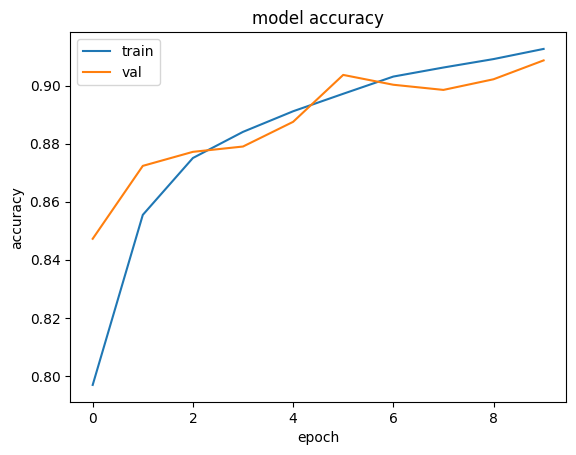

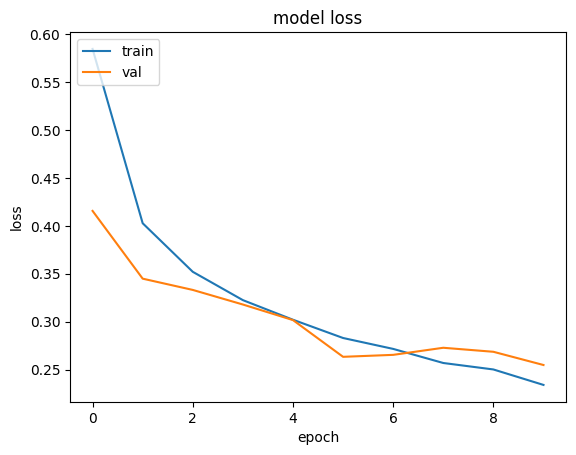

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

###Monitoreo de filtros

In [ ]:
def graficar(w, p='filtro',figsize=(20,20)):
    plt.figure(figsize=figsize)
    for i in range(w.shape[-1]):
        plt.subplot(10,10,i+1)
        if p=='filtro':
          plt.imshow(w[:,:,0,i],cmap='gray')
        else :
          plt.imshow(w[0,:,:,i],cmap='gray')
        plt.axis("off")

In [ ]:
selected_layer = model.layers[0].name #'conv2d' layer name
layer_output=model.get_layer(selected_layer).output
intermediate_model=tf.keras.models.Model(inputs=model.inputs,outputs=layer_output)

image = test_images[0]
image=np.reshape(image,(1,28,28,1))
intermediate_prediction=intermediate_model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


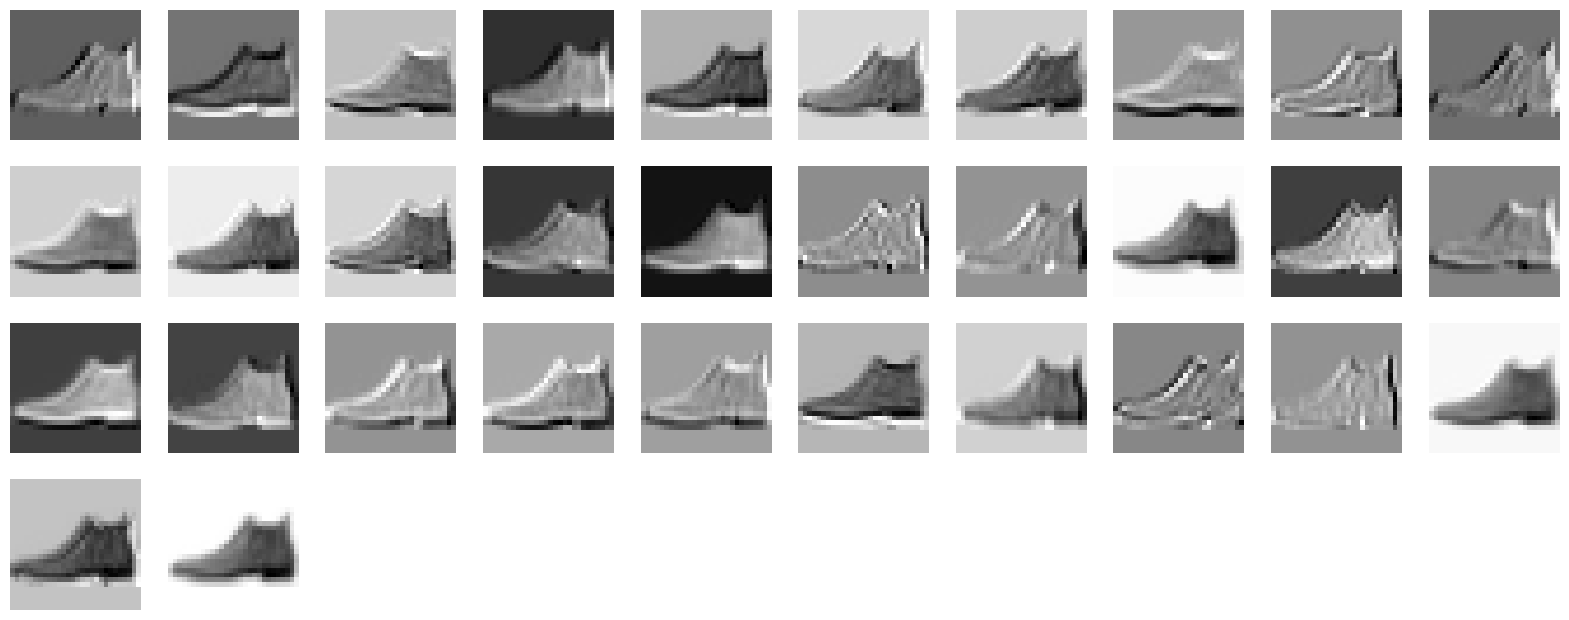

In [ ]:
##Visualizar mapas de caracteristicas
graficar(intermediate_prediction,'mapas')

###Evaluar la cnn

In [ ]:
y_pred = np.argmax(model.predict(test_images), axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
print("First 10 predicted labels:", y_pred[:10])
print("First 10 actual labels:", y_test[:10])

First 10 predicted labels: [9 2 1 1 6 1 4 6 5 7]
First 10 actual labels: [9 2 1 1 6 1 4 6 5 7]


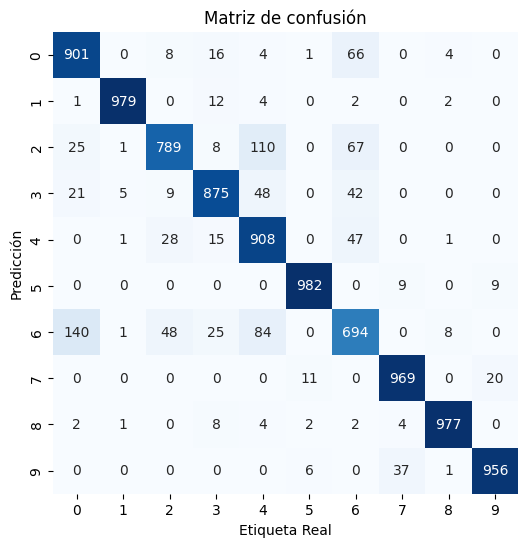

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap='Blues', cbar=False, fmt='g')
plt.xlabel('Etiqueta Real')
plt.ylabel('Predicción')
plt.title('Matriz de confusión')
plt.show()

In [ ]:
# Accuracy
accuracy_s = accuracy_score(y_test,y_pred)
print('accuracy_score: {0:.6f}'.format(accuracy_s))
# Precision
precision_s = precision_score(y_test,y_pred,average='weighted')
print('precision_score: {0:.6f}'.format(precision_s))
# Recall
recall_s = recall_score(y_test,y_pred,average='weighted')
print('recall_score: {0:.6f}'.format(recall_s))
# F1-score
f1_s = f1_score(y_test,y_pred,average='weighted')
print('f1_score: {0:.6f}'.format(f1_s))

accuracy_score: 0.903000
precision_score: 0.904564
recall_score: 0.903000
f1_score: 0.902633


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1000
           1       0.99      0.98      0.98      1000
           2       0.89      0.79      0.84      1000
           3       0.91      0.88      0.89      1000
           4       0.78      0.91      0.84      1000
           5       0.98      0.98      0.98      1000
           6       0.75      0.69      0.72      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



##Segunda rama de transfer learning con capas convolucionales no entrenables

<>:111: SyntaxWarning: invalid escape sequence '\ '
<>:111: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-1706905270.py:111: SyntaxWarning: invalid escape sequence '\ '
  print("\ Modelo (Fine-tuning):")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Entrenando modelo (fine-tuning)...
Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 71s 28ms/step - accuracy: 0.7069 - loss: 0.8694 - learning_rate: 1.0000e-04
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 53s 28ms/step - accuracy: 0.8581 - loss: 0.3967 - learning_rate: 1.0000e-04
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.8781 - loss: 0.3367 - learning_rate: 1.0000e-04
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 56s 30ms/step - accuracy: 0.8878 - loss: 0.3090 - learning_rate: 1.0000e-04
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 54s 29ms/step - accuracy: 0.8952 - loss: 0.2863 - learning_rate: 1.0000e-04
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 53s 28ms/step - accuracy: 0.9018 - loss: 0.2721 - learning_rate: 1.0000e-04
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.9077 - loss: 0.2564 - learning_rate: 1.0000e-04
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 28ms/step - accuracy: 0.9096 - loss: 0.2484

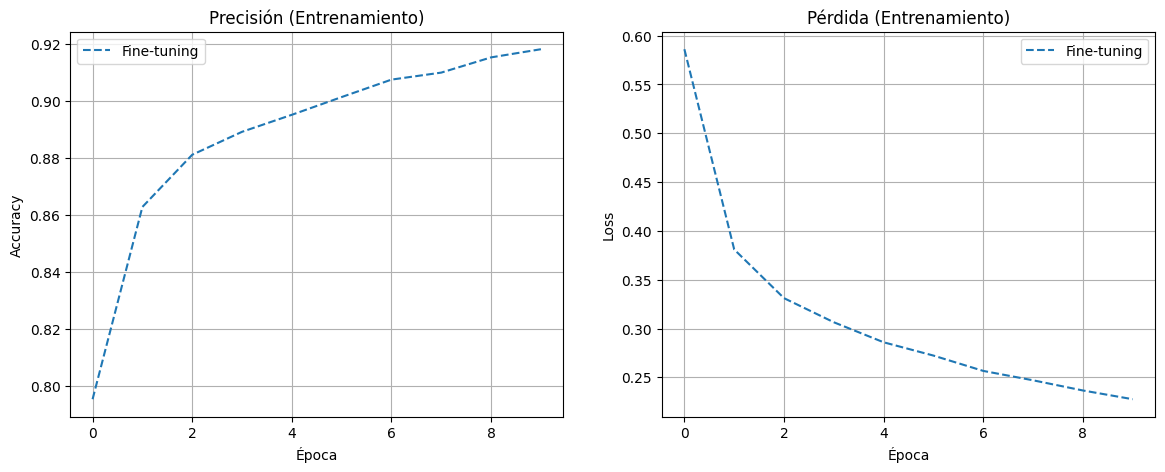

\ Modelo (Fine-tuning):
   - Pérdida: 0.2577
   - Precisión: 0.9061


In [ ]:

# ---------------------------------------
# FUNCIÓN PARA CONSTRUIR EL MODELO
# ---------------------------------------
def build_mobilenet_model(trainable_convs=False, num_classes=10):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Congelar todas las capas convolucionales para evitar reentrenamiento
    for layer in base_model.layers:
        layer.trainable = False

    # Nueva cabeza (Fully Connected)
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256,activation='relu')(x)
    #Elimina el 50% de las neuronas para evitar overfitting
    x = layers.Dropout(0.5)(x)
    #Capa de salida para 10 clases
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ---------------------------------
# PREPROCESAR LOS DATOS con tf.data
# ---------------------------------
# One-hot encode primero
num_classes = 10
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Crear datasets SIN reshape previo (X_train y X_test deben ser (num_samples, 28, 28))
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_one_hot))

# Función de preprocesamiento Transforma imágenes MNIST (28x28, escala de grises) al formato que espera MobileNetV2
def preprocess_image(image, label):
    # Reshape si está aplanada (784,) -> (28, 28)
    image = tf.reshape(image, (28, 28))
    # Expandir a (28, 28, 1)
    image = tf.expand_dims(image, -1)
    # Convertir a RGB (28, 28, 3)
    image = tf.image.grayscale_to_rgb(image)
    # Redimensionar a (224, 224, 3)
    image = tf.image.resize(image, (224, 224))
    # Normalización de MobileNetV2
    image = preprocess_input(image)
    return image, label

#Tamaño del conjunto de datos
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Aplicar preprocesamiento a los datasets
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# ---------------------------------------
# ENTRENAR MODELO
# ---------------------------------------
model_finetune = build_mobilenet_model(trainable_convs=False, num_classes=num_classes)

# Callback: reducir LR si se estanca, el learning rate controla el ajuste de los pesos en cada iteracin, es bajito por el fine tunning
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1
)

print("\nEntrenando modelo (fine-tuning)...")
history_finetune = model_finetune.fit(train_dataset, epochs=10, verbose=1, callbacks=[lr_scheduler])

# ---------------------------------------
# GRAFICAR CURVAS
# ---------------------------------------
def plot_training_curves(history, label="Fine-tuning"):
    plt.figure(figsize=(14,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label=label, linestyle='--')
    plt.title('Precisión (Entrenamiento)')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label=label, linestyle='--')
    plt.title('Pérdida (Entrenamiento)')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_training_curves(history_finetune)

# ---------------------------------------
# EVALUAR MODELO
# ---------------------------------------
test_loss_ft, test_acc_ft = model_finetune.evaluate(test_dataset, verbose=0)

print("\ Modelo sin tunear:")
print(f"   - Pérdida: {test_loss_ft:.4f}")
print(f"   - Precisión: {test_acc_ft:.4f}")

##Tercera rama CNN 1d

Dataset cargado:
X_train shape: (60000, 784)
y_train shape: (60000,)
X_test shape: (10000, 784)
y_test shape: (10000,)

Dataset procesado:
- X shape: (60000, 784, 1)
- y shape: (60000,)
- Rango de valores X: 0.000 a 1.000
- Clases únicas: [0 1 2 3 4 5 6 7 8 9]
- Distribución de clases:
  Clase 0: 6000 muestras
  Clase 1: 6000 muestras
  Clase 2: 6000 muestras
  Clase 3: 6000 muestras
  Clase 4: 6000 muestras
  Clase 5: 6000 muestras
  Clase 6: 6000 muestras
  Clase 7: 6000 muestras
  Clase 8: 6000 muestras
  Clase 9: 6000 muestras
Dataset procesado:
- X shape: (10000, 784, 1)
- y shape: (10000,)
- Rango de valores X: 0.000 a 1.000
- Clases únicas: [0 1 2 3 4 5 6 7 8 9]
- Distribución de clases:
  Clase 0: 1000 muestras
  Clase 1: 1000 muestras
  Clase 2: 1000 muestras
  Clase 3: 1000 muestras
  Clase 4: 1000 muestras
  Clase 5: 1000 muestras
  Clase 6: 1000 muestras
  Clase 7: 1000 muestras
  Clase 8: 1000 muestras
  Clase 9: 1000 muestras

Visualizando muestras del conjunto de entrena

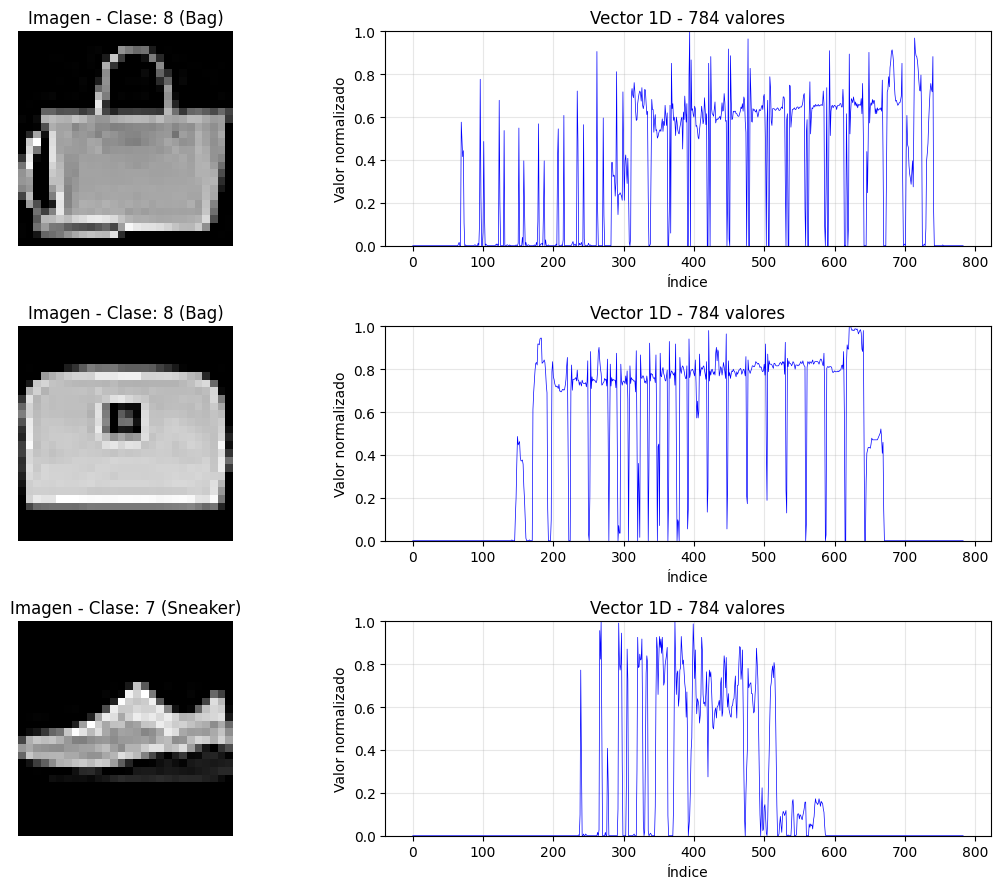

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
import os

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels


def prepare_data_for_cnn1d(X, y, normalize=True, show_summary=True):
    """
    Prepara los datos de Fashion MNIST para CNN 1D.

    Args:
        X: array de imágenes aplanadas con shape (N, 784)
        y: array de etiquetas con shape (N,)
        normalize: si normalizar los datos al rango [0, 1]
        show_summary: si mostrar resumen de los datos

    Returns:
        X_processed: array con shape (N, 784, 1) listo para CNN 1D
        y: array de etiquetas sin cambios
    """
    # Normalizar al rango [0, 1] si es necesario
    if normalize:
        X_processed = X.astype('float32') / 255.0
    else:
        X_processed = X.astype('float32')

    # Agregar dimensión de canal para CNN 1D
    # (N, 784) -> (N, 784, 1)
    # N: número de muestras, 784: longitud del vector, 1: un solo canal
    X_processed = np.expand_dims(X_processed, axis=-1)

    if show_summary:
        print(f"Dataset procesado:")
        print(f"- X shape: {X_processed.shape}")
        print(f"- y shape: {y.shape}")
        print(f"- Rango de valores X: {X_processed.min():.3f} a {X_processed.max():.3f}")
        print(f"- Clases únicas: {np.unique(y)}")
        print(f"- Distribución de clases:")
        for clase, count in enumerate(np.bincount(y)):
            print(f"  Clase {clase}: {count} muestras")

    return X_processed, y


def visualize_samples(X, y, n_samples=5, random_state=42):
    """
    Visualiza muestras aleatorias del dataset como imágenes y vectores.

    Args:
        X: array con shape (N, 784) o (N, 784, 1)
        y: array de etiquetas
        n_samples: número de muestras a visualizar
        random_state: semilla para reproducibilidad
    """
    np.random.seed(random_state)

    # Si X tiene 3 dimensiones, quitar la dimensión del canal
    if len(X.shape) == 3:
        X_viz = X.squeeze()
    else:
        X_viz = X

    # Normalizar si no está normalizado
    if X_viz.max() > 1:
        X_viz = X_viz / 255.0

    # Seleccionar muestras aleatorias
    indices = np.random.choice(len(X_viz), n_samples, replace=False)

    fig, axes = plt.subplots(n_samples, 2, figsize=(12, 3*n_samples))

    for i, idx in enumerate(indices):
        # Mostrar imagen 2D
        imagen_2d = X_viz[idx].reshape(28, 28)
        axes[i, 0].imshow(imagen_2d, cmap='gray')
        axes[i, 0].set_title(f"Imagen - Clase: {y[idx]} ({FASHION_MNIST_CLASSES[y[idx]]})")
        axes[i, 0].axis('off')

        # Mostrar vector 1D como señal
        vector_1d = X_viz[idx]
        axes[i, 1].plot(vector_1d, linewidth=0.5, color='blue')
        axes[i, 1].set_title(f"Vector 1D - 784 valores")
        axes[i, 1].set_xlabel("Índice")
        axes[i, 1].set_ylabel("Valor normalizado")
        axes[i, 1].grid(True, alpha=0.3)
        axes[i, 1].set_ylim([0, 1])

    plt.tight_layout()
    plt.show()


# Mapeo de clases de Fashion MNIST
FASHION_MNIST_CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


# === USO DEL CÓDIGO ===

# 1. Cargar el dataset
X_train, y_train = load_mnist('/content/drive/MyDrive/fashion', kind='train')
X_test, y_test = load_mnist('/content/drive/MyDrive/fashion', kind='t10k')

print("Dataset cargado:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print()

# 2. Preparar datos para CNN 1D
X_train_cnn, y_train = prepare_data_for_cnn1d(X_train, y_train)
X_test_cnn, y_test = prepare_data_for_cnn1d(X_test, y_test)
print()

# 3. Visualizar algunas muestras
print("Visualizando muestras del conjunto de entrenamiento:")
visualize_samples(X_train, y_train, n_samples=3)

Usando dispositivo: cuda

Tamaños de los conjuntos:
Train: 48000
Val: 12000
Test: 10000


/tmp/ipython-input-2129383941.py:350: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  y_train_tensor = torch.LongTensor(y_train)



Parámetros del modelo:
Total: 14,417,226
Entrenables: 14,417,226

INICIANDO ENTRENAMIENTO

Epoch 1/30
------------------------------------------------------------


Train Loss: 0.7514 | Train Acc: 0.7537
Val Loss: 0.4282 | Val Acc: 0.8434
LR: 0.001000
✓ Modelo guardado (Val Acc: 0.8434)

Epoch 2/30
------------------------------------------------------------


Train Loss: 0.4624 | Train Acc: 0.8359
Val Loss: 0.3542 | Val Acc: 0.8700
LR: 0.001000
✓ Modelo guardado (Val Acc: 0.8700)

Epoch 3/30
------------------------------------------------------------


Train Loss: 0.4115 | Train Acc: 0.8552
Val Loss: 0.3313 | Val Acc: 0.8806
LR: 0.001000
✓ Modelo guardado (Val Acc: 0.8806)

Epoch 4/30
------------------------------------------------------------


Train Loss: 0.3759 | Train Acc: 0.8674
Val Loss: 0.3046 | Val Acc: 0.8899
LR: 0.001000
✓ Modelo guardado (Val Acc: 0.8899)

Epoch 5/30
------------------------------------------------------------


Train Loss: 0.3486 | Train Acc: 0.8758
Val Loss: 0.3035 | Val Acc: 0.8892
LR: 0.001000

Epoch 6/30
------------------------------------------------------------


Train Loss: 0.3300 | Train Acc: 0.8826
Val Loss: 0.2974 | Val Acc: 0.8931
LR: 0.001000
✓ Modelo guardado (Val Acc: 0.8931)

Epoch 7/30
------------------------------------------------------------


Train Loss: 0.3149 | Train Acc: 0.8892
Val Loss: 0.2980 | Val Acc: 0.8906
LR: 0.001000

Epoch 8/30
------------------------------------------------------------


Train Loss: 0.2994 | Train Acc: 0.8933
Val Loss: 0.2566 | Val Acc: 0.9078
LR: 0.001000
✓ Modelo guardado (Val Acc: 0.9078)

Epoch 9/30
------------------------------------------------------------


Train Loss: 0.2807 | Train Acc: 0.9005
Val Loss: 0.2556 | Val Acc: 0.9106
LR: 0.001000
✓ Modelo guardado (Val Acc: 0.9106)

Epoch 10/30
------------------------------------------------------------


Train Loss: 0.2739 | Train Acc: 0.9019
Val Loss: 0.2760 | Val Acc: 0.9028
LR: 0.000100

Epoch 11/30
------------------------------------------------------------


Train Loss: 0.2269 | Train Acc: 0.9196
Val Loss: 0.2373 | Val Acc: 0.9180
LR: 0.000100
✓ Modelo guardado (Val Acc: 0.9180)

Epoch 12/30
------------------------------------------------------------


Train Loss: 0.2066 | Train Acc: 0.9251
Val Loss: 0.2334 | Val Acc: 0.9187
LR: 0.000100
✓ Modelo guardado (Val Acc: 0.9187)

Epoch 13/30
------------------------------------------------------------


Train Loss: 0.2018 | Train Acc: 0.9262
Val Loss: 0.2327 | Val Acc: 0.9192
LR: 0.000100
✓ Modelo guardado (Val Acc: 0.9192)

Epoch 14/30
------------------------------------------------------------


Train Loss: 0.1952 | Train Acc: 0.9289
Val Loss: 0.2306 | Val Acc: 0.9185
LR: 0.000100

Epoch 15/30
------------------------------------------------------------


Train Loss: 0.1877 | Train Acc: 0.9307
Val Loss: 0.2330 | Val Acc: 0.9202
LR: 0.000100
✓ Modelo guardado (Val Acc: 0.9202)

Epoch 16/30
------------------------------------------------------------


Train Loss: 0.1870 | Train Acc: 0.9301
Val Loss: 0.2352 | Val Acc: 0.9199
LR: 0.000100

Epoch 17/30
------------------------------------------------------------


Train Loss: 0.1790 | Train Acc: 0.9327
Val Loss: 0.2411 | Val Acc: 0.9214
LR: 0.000100
✓ Modelo guardado (Val Acc: 0.9214)

Epoch 18/30
------------------------------------------------------------


Train Loss: 0.1770 | Train Acc: 0.9344
Val Loss: 0.2361 | Val Acc: 0.9216
LR: 0.000100
✓ Modelo guardado (Val Acc: 0.9216)

Epoch 19/30
------------------------------------------------------------


Train Loss: 0.1746 | Train Acc: 0.9363
Val Loss: 0.2385 | Val Acc: 0.9225
LR: 0.000100
✓ Modelo guardado (Val Acc: 0.9225)

Epoch 20/30
------------------------------------------------------------


Train Loss: 0.1688 | Train Acc: 0.9370
Val Loss: 0.2385 | Val Acc: 0.9211
LR: 0.000010

Epoch 21/30
------------------------------------------------------------


Train Loss: 0.1611 | Train Acc: 0.9390
Val Loss: 0.2406 | Val Acc: 0.9226
LR: 0.000010
✓ Modelo guardado (Val Acc: 0.9226)

Epoch 22/30
------------------------------------------------------------


Train Loss: 0.1578 | Train Acc: 0.9402
Val Loss: 0.2418 | Val Acc: 0.9237
LR: 0.000010
✓ Modelo guardado (Val Acc: 0.9237)

Epoch 23/30
------------------------------------------------------------


Train Loss: 0.1588 | Train Acc: 0.9399
Val Loss: 0.2429 | Val Acc: 0.9237
LR: 0.000010

Epoch 24/30
------------------------------------------------------------


Train Loss: 0.1593 | Train Acc: 0.9402
Val Loss: 0.2409 | Val Acc: 0.9227
LR: 0.000010

Epoch 25/30
------------------------------------------------------------


Train Loss: 0.1571 | Train Acc: 0.9408
Val Loss: 0.2419 | Val Acc: 0.9233
LR: 0.000010

Epoch 26/30
------------------------------------------------------------


Train Loss: 0.1569 | Train Acc: 0.9411
Val Loss: 0.2409 | Val Acc: 0.9230
LR: 0.000010

Epoch 27/30
------------------------------------------------------------


Train Loss: 0.1534 | Train Acc: 0.9431
Val Loss: 0.2438 | Val Acc: 0.9233
LR: 0.000010

Epoch 28/30
------------------------------------------------------------


Train Loss: 0.1552 | Train Acc: 0.9417
Val Loss: 0.2435 | Val Acc: 0.9230
LR: 0.000010

Epoch 29/30
------------------------------------------------------------


Train Loss: 0.1535 | Train Acc: 0.9416
Val Loss: 0.2433 | Val Acc: 0.9229
LR: 0.000010

Epoch 30/30
------------------------------------------------------------


Train Loss: 0.1515 | Train Acc: 0.9429
Val Loss: 0.2433 | Val Acc: 0.9233
LR: 0.000001

Entrenamiento completado en 17.14 minutos
Mejor Val Acc: 0.9237


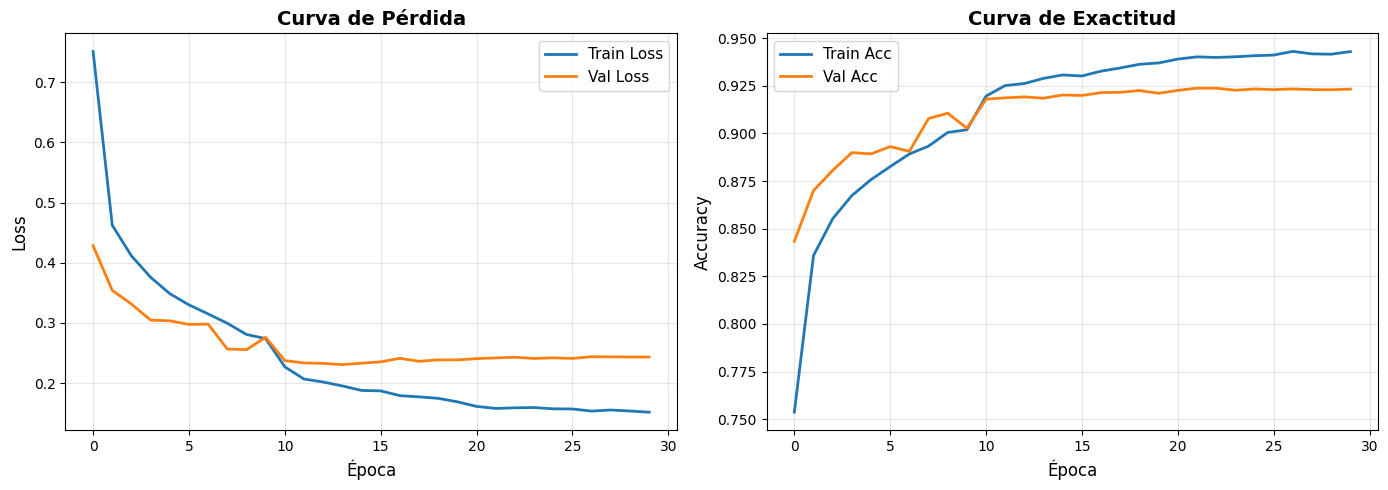

Curvas guardadas en: training_curves.png

Mejor modelo cargado para evaluación final.


Testing: 100%|██████████| 157/157 [00:01<00:00, 90.02it/s]



MÉTRICAS DE EVALUACIÓN EN TEST SET
Accuracy:  0.9165
Precision: 0.9158
Recall:    0.9165
F1-Score:  0.9160

REPORTE DE CLASIFICACIÓN POR CLASE:
------------------------------------------------------------
              precision    recall  f1-score   support

 T-shirt/top     0.8627    0.8800    0.8713      1000
     Trouser     0.9939    0.9830    0.9884      1000
    Pullover     0.8787    0.8840    0.8814      1000
       Dress     0.9062    0.9270    0.9165      1000
        Coat     0.8648    0.8830    0.8738      1000
      Sandal     0.9838    0.9720    0.9779      1000
       Shirt     0.7740    0.7190    0.7455      1000
     Sneaker     0.9509    0.9680    0.9594      1000
         Bag     0.9782    0.9870    0.9826      1000
  Ankle boot     0.9649    0.9620    0.9634      1000

    accuracy                         0.9165     10000
   macro avg     0.9158    0.9165    0.9160     10000
weighted avg     0.9158    0.9165    0.9160     10000



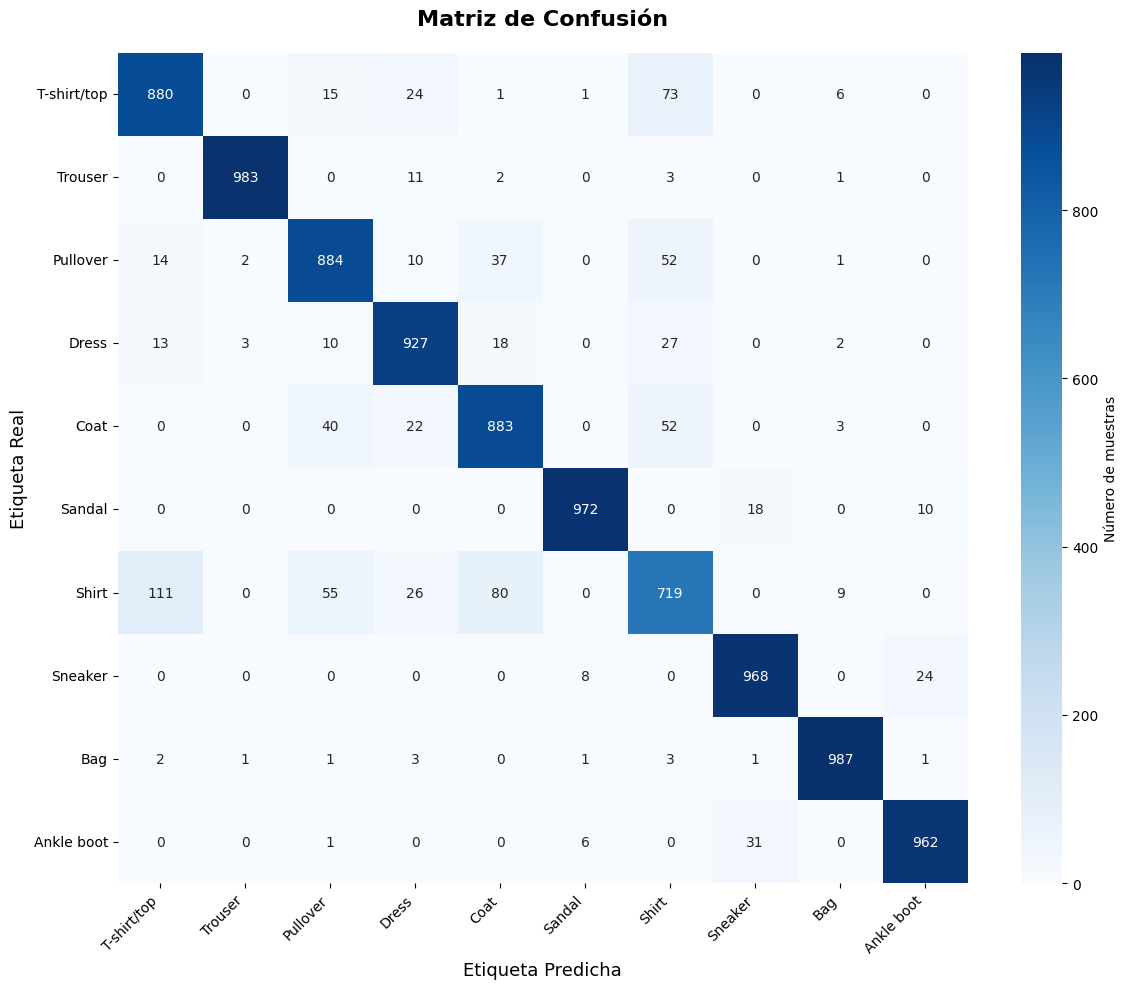

Matriz de confusión guardada en: confusion_matrix.png


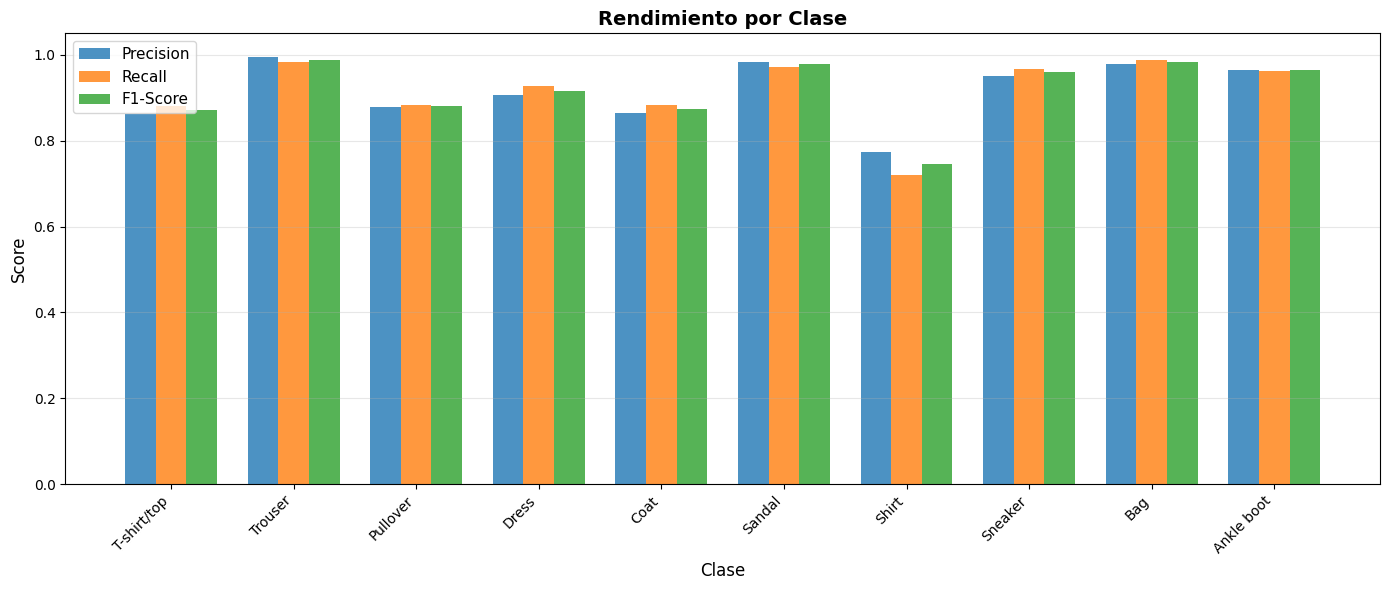

Gráfico de rendimiento por clase guardado en: class_performance.png


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
import seaborn as sns
from tqdm import tqdm
import time

# Arquitectura VGG1D
class VGG1D(nn.Module):
    """Arquitectura inspirada en VGG para señales 1D"""
    def __init__(self, input_length, num_classes=10):
        super(VGG1D, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv1d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Conv1d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv1d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
        )

        # Calcular tamaño después de poolings
        feature_size = input_length // (2**4)  # 4 MaxPool1d con stride=2

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * feature_size, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def train_epoch(model, dataloader, criterion, optimizer, device):
    """Entrena el modelo por una época"""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    """Valida el modelo"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc, all_preds, all_labels


def train_model(model, train_loader, val_loader, criterion, optimizer,
                scheduler, num_epochs, device, save_path='best_model.pth'):
    """Entrena el modelo completo"""

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val_acc = 0.0
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 60)

        # Entrenar
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validar
        val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)

        # Actualizar learning rate
        scheduler.step()

        # Guardar historia
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
        print(f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

        # Guardar mejor modelo
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f'✓ Modelo guardado (Val Acc: {val_acc:.4f})')

    total_time = time.time() - start_time
    print(f'\nEntrenamiento completado en {total_time/60:.2f} minutos')
    print(f'Mejor Val Acc: {best_val_acc:.4f}')

    return history


def plot_training_curves(history, save_path='training_curves.png'):
    """Grafica las curvas de entrenamiento"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Época', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Curva de Pérdida', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(history['train_acc'], label='Train Acc', linewidth=2)
    axes[1].plot(history['val_acc'], label='Val Acc', linewidth=2)
    axes[1].set_xlabel('Época', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Curva de Exactitud', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Curvas guardadas en: {save_path}")


def evaluate_model(model, test_loader, device, class_names):
    """Evalúa el modelo y genera métricas detalladas"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Métricas globales
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print("\n" + "="*60)
    print("MÉTRICAS DE EVALUACIÓN EN TEST SET")
    print("="*60)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print("="*60)

    # Reporte de clasificación
    print("\nREPORTE DE CLASIFICACIÓN POR CLASE:")
    print("-"*60)
    print(classification_report(all_labels, all_preds,
                               target_names=class_names,
                               digits=4))

    # Matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }


def plot_confusion_matrix(cm, class_names, save_path='confusion_matrix.png'):
    """Grafica la matriz de confusión"""
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Número de muestras'})
    plt.title('Matriz de Confusión', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Etiqueta Real', fontsize=13)
    plt.xlabel('Etiqueta Predicha', fontsize=13)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Matriz de confusión guardada en: {save_path}")


def plot_class_performance(results, class_names, save_path='class_performance.png'):
    """Grafica el rendimiento por clase"""
    from sklearn.metrics import precision_score, recall_score, f1_score

    labels = results['labels']
    preds = results['predictions']

    # Calcular métricas por clase
    precision_per_class = precision_score(labels, preds, average=None)
    recall_per_class = recall_score(labels, preds, average=None)
    f1_per_class = f1_score(labels, preds, average=None)

    x = np.arange(len(class_names))
    width = 0.25

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.bar(x - width, precision_per_class, width, label='Precision', alpha=0.8)
    ax.bar(x, recall_per_class, width, label='Recall', alpha=0.8)
    ax.bar(x + width, f1_per_class, width, label='F1-Score', alpha=0.8)

    ax.set_xlabel('Clase', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Rendimiento por Clase', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1.05])

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Gráfico de rendimiento por clase guardado en: {save_path}")


# Mapeo de clases
FASHION_MNIST_CLASSES = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]


# ============================================================================
# EJEMPLO DE USO COMPLETO
# ============================================================================

def main(X_train_cnn, y_train, X_test_cnn, y_test,
         batch_size=64, num_epochs=30, learning_rate=0.001):
    """
    Función principal para entrenar y evaluar el modelo.

    Args:
        X_train_cnn: datos de entrenamiento con shape (N, 784, 1)
        y_train: etiquetas de entrenamiento
        X_test_cnn: datos de test con shape (N, 784, 1)
        y_test: etiquetas de test
        batch_size: tamaño del batch
        num_epochs: número de épocas
        learning_rate: tasa de aprendizaje inicial
    """

    # Configuración del dispositivo
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Usando dispositivo: {device}")

    # Convertir datos a tensores de PyTorch
    # PyTorch espera (N, C, L) donde C=canales, L=longitud
    X_train_tensor = torch.FloatTensor(X_train_cnn).permute(0, 2, 1)  # (N, 1, 784)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test_cnn).permute(0, 2, 1)
    y_test_tensor = torch.LongTensor(y_test)

    # Crear datasets y dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Split train en train/val (80/20)
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_subset, val_subset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"\nTamaños de los conjuntos:")
    print(f"Train: {len(train_subset)}")
    print(f"Val: {len(val_subset)}")
    print(f"Test: {len(test_dataset)}")

    # Crear modelo
    input_length = 784
    num_classes = 10
    model = VGG1D(input_length=input_length, num_classes=num_classes).to(device)

    # Contar parámetros
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nParámetros del modelo:")
    print(f"Total: {total_params:,}")
    print(f"Entrenables: {trainable_params:,}")

    # Definir loss, optimizer y scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Entrenar
    print("\n" + "="*60)
    print("INICIANDO ENTRENAMIENTO")
    print("="*60)
    history = train_model(model, train_loader, val_loader, criterion,
                         optimizer, scheduler, num_epochs, device)

    # Graficar curvas de entrenamiento
    plot_training_curves(history)

    # Cargar mejor modelo
    model.load_state_dict(torch.load('best_model.pth'))
    print("\nMejor modelo cargado para evaluación final.")

    # Evaluar en test set
    results = evaluate_model(model, test_loader, device, FASHION_MNIST_CLASSES)

    # Graficar matriz de confusión
    plot_confusion_matrix(results['confusion_matrix'], FASHION_MNIST_CLASSES)

    # Graficar rendimiento por clase
    plot_class_performance(results, FASHION_MNIST_CLASSES)

    return model, history, results


# Para ejecutar:
model, history, results = main(X_train_cnn, y_train, X_test_cnn, y_test,batch_size=64, num_epochs=30, learning_rate=0.001)

#Arquitectura Multimodal COMPLETA

Funciones usadas
ReLU permite aprender características complejas, pues introduce no linealidad y permite aprender patrones complejos

Softmax da probabilidades interpretables

Crossentropy mide directamente qué tan buenas son esas probabilidades, diseñada para multiclase, y combina con softmax



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │        320 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 784, 1)    │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 784, 32)   │        128 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 392, 32)   │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 392, 64)   │      6,208 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 7, 7, 64)  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_5[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 196, 64)   │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 3136)      │          0 │ max_pooling2d_3[

 Total params: 3,673,290 (14.01 MB)

 Trainable params: 1,415,114 (5.40 MB)

 Non-trainable params: 2,258,176 (8.61 MB)

Entrenando modelo multimodal con tf.data...
Epoch 1/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 93s 43ms/step - accuracy: 0.4969 - loss: 1.4325 - val_accuracy: 0.8544 - val_loss: 0.4090 - learning_rate: 1.0000e-04
Epoch 2/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 117s 40ms/step - accuracy: 0.8073 - loss: 0.5669 - val_accuracy: 0.8869 - val_loss: 0.3198 - learning_rate: 1.0000e-04
Epoch 3/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 61s 41ms/step - accuracy: 0.8519 - loss: 0.4432 - val_accuracy: 0.9021 - val_loss: 0.2869 - learning_rate: 1.0000e-04
Epoch 4/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - accuracy: 0.8701 - loss: 0.3829 - val_accuracy: 0.9086 - val_loss: 0.2628 - learning_rate: 1.0000e-04
Epoch 5/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 40ms/step - accuracy: 0.8874 - loss: 0.3359 - val_accuracy: 0.9122 - val_loss: 0.2483 - learning_rate: 1.0000e-04
Epoch 6/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 61s 41ms/step - accuracy: 0.8947 - loss: 0.3130 - val_accuracy: 0.9145 - val_loss: 0.2437 - learning_rate: 1.0000

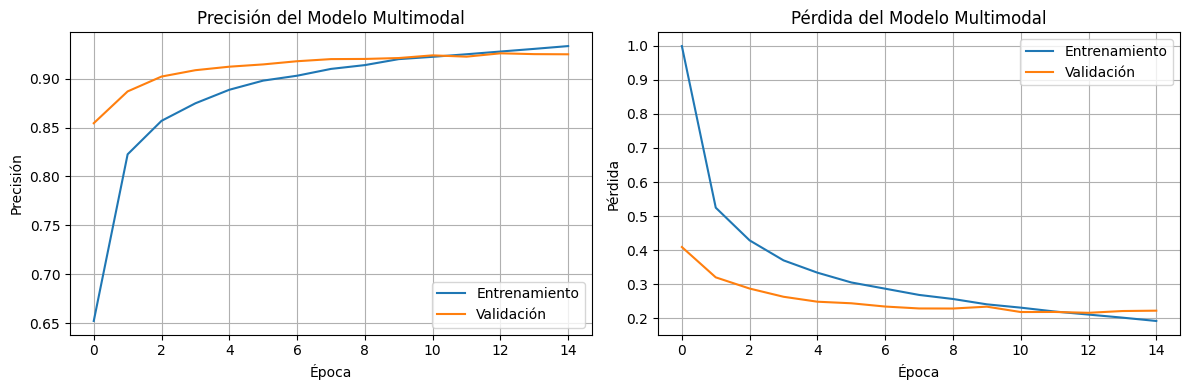

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np # Import numpy

# 1. DEFINIR LAS ENTRADAS
input_2d = tf.keras.layers.Input(shape=(28, 28, 1))  # Rama 1: CNN 2D
input_tl = tf.keras.layers.Input(shape=(224, 224, 3))  # Rama 2: Transfer Learning
input_1d = tf.keras.layers.Input(shape=(784,))  # Rama 3: Imagen vectorizada

# 2. RAMA 1 - ARQUITECTURA CONVOLUCIONAL 2D
def build_cnn_2d_branch(input_layer):
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    return x

# 3. RAMA 2 - TRANSFER LEARNING (MobileNetV2)
def build_transfer_learning_branch(input_layer):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Congelar capas convolucionales
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model(input_layer)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    return x

# 4. RAMA 3 - CONVOLUCIONES 1D
def build_1d_cnn_branch(input_layer):
    # Redimensionar para convoluciones 1D
    x = tf.keras.layers.Reshape((784, 1))(input_layer)

    x = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling1D(2)(x)

    x = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling1D(2)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    return x

# 5. CONSTRUIR LAS TRES RAMAS
branch_2d = build_cnn_2d_branch(input_2d)
branch_tl = build_transfer_learning_branch(input_tl)
branch_1d = build_1d_cnn_branch(input_1d)

# 6. CONCATENAR CARACTERÍSTICAS
concatenated = tf.keras.layers.concatenate([branch_2d, branch_tl, branch_1d])

# 7. CAPAS FULLY CONNECTED FINALES
x = tf.keras.layers.Dense(128, activation='relu')(concatenated)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(10, activation='softmax')(x)

# 8. CREAR MODELO MULTIMODAL
multimodal_model = tf.keras.Model(
    inputs=[input_2d, input_tl, input_1d],
    outputs=output
)

# 9. COMPILAR EL MODELO
multimodal_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Ver arquitectura
multimodal_model.summary()

# ==========================================
# PREPARAR DATOS CON TF.DATA
# ==========================================

def preprocess_multimodal_sample(image, label):
    # Preprocess for Branch 1 (CNN 2D)
    image_2d = tf.reshape(image, (28, 28, 1))
    image_2d = tf.cast(image_2d, tf.float32) / 255.0 # Normalize

    # Preprocess for Branch 2 (Transfer Learning)
    # Need to expand dims to (28, 28, 1) before rgb conversion
    image_tl_interim = tf.expand_dims(tf.cast(tf.reshape(image, (28, 28)), tf.float32), -1)
    image_tl_rgb = tf.image.grayscale_to_rgb(image_tl_interim)
    image_tl_resized = tf.image.resize(image_tl_rgb, [224, 224])
    image_tl_processed = preprocess_input(image_tl_resized)

    # Preprocess for Branch 3 (CNN 1D)
    image_1d = tf.cast(tf.reshape(image, (784,)), tf.float32) / 255.0 # Cast to float32 before division

    # One-hot encode label
    label_one_hot = tf.one_hot(label, 10)

    # Return tuple of inputs and the output
    return (image_2d, image_tl_processed, image_1d), label_one_hot

def create_multimodal_dataset(X, y, batch_size=32, shuffle=True):
    # Create dataset from raw X and y
    raw_dataset = tf.data.Dataset.from_tensor_slices((X, y))

    if shuffle:
        raw_dataset = raw_dataset.shuffle(buffer_size=len(X)) # Shuffle the dataset

    # Apply the multimodal preprocessing
    processed_dataset = raw_dataset.map(preprocess_multimodal_sample, num_parallel_calls=tf.data.AUTOTUNE)

    # Batch and prefetch
    batched_dataset = processed_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return batched_dataset

# Assuming X_train, y_train, X_test, y_test are already loaded and are raw NumPy arrays

# Split data for validation manually as tf.data.Dataset doesn't have validation_split
validation_split = 0.2
num_train_samples = X_train.shape[0]
num_val_samples = int(validation_split * num_train_samples)
num_train_samples -= num_val_samples

X_train_split, X_val_split = X_train[:num_train_samples], X_train[num_train_samples:]
y_train_split, y_val_split = y_train[:num_train_samples], y_train[num_train_samples:]

# Create the combined datasets using the new function
batch_size = 32
train_dataset_combined = create_multimodal_dataset(X_train_split, y_train_split, batch_size=batch_size, shuffle=True)
val_dataset_combined = create_multimodal_dataset(X_val_split, y_val_split, batch_size=batch_size, shuffle=False)
test_dataset_combined = create_multimodal_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)


print("Entrenando modelo multimodal con tf.data...")

history_multimodal = multimodal_model.fit(
    train_dataset_combined,
    epochs=15,
    validation_data=val_dataset_combined,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True
        )
    ],
    verbose=1
)

# ==========================================
# EVALUAR MODELO MULTIMODAL
# ==========================================

test_loss, test_acc = multimodal_model.evaluate(
    test_dataset_combined,
    verbose=0
)

print(f"\nModelo Multimodal - Precisión en prueba: {test_acc:.4f}")

# ==========================================
# GRÁFICAS DE CURVAS DE ENTRENAMIENTO
# ==========================================

plt.figure(figsize=(12, 4))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history_multimodal.history['accuracy'], label='Entrenamiento')
plt.plot(history_multimodal.history['val_accuracy'], label='Validación')
plt.title('Precisión del Modelo Multimodal')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history_multimodal.history['loss'], label='Entrenamiento')
plt.plot(history_multimodal.history['val_loss'], label='Validación')
plt.title('Pérdida del Modelo Multimodal')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Extrayendo características del modelo entrenado...
- Procesando conjunto de entrenamiento...
- Procesando conjunto de prueba...

Vector de características extraído (train): (48000, 128)
Vector de características extraído (test): (10000, 128)
Etiquetas de entrenamiento: (48000,)
Etiquetas de prueba: (10000,)

ENTRENANDO CLASIFICADORES INDIVIDUALES

Entrenando SVM...
SVM                  -> Precisión: 0.9238

Entrenando RandomForest...
RandomForest         -> Precisión: 0.9237

Entrenando LogisticRegression...
LogisticRegression   -> Precisión: 0.9207

Entrenando KNN...
KNN                  -> Precisión: 0.9204

Entrenando HistGradientBoosting...
Binning 0.044 GB of training data: 0.605 s
Binning 0.005 GB of validation data: 0.030 s
Fitting gradient boosted rounds:
Fit 450 trees in 19.035 s, (13950 total leaves)
Time spent computing histograms: 13.018s
Time spent finding best splits:  3.268s
Time spent applying splits:      0.686s
Time spent predicting:           0.056s
HistGradientBoost

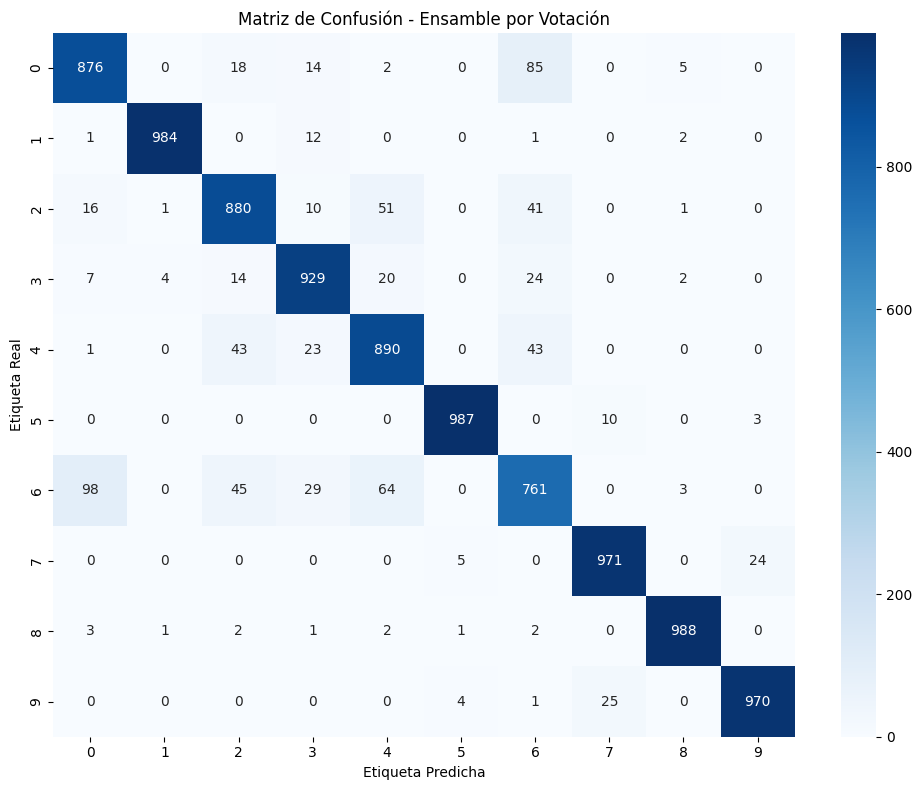

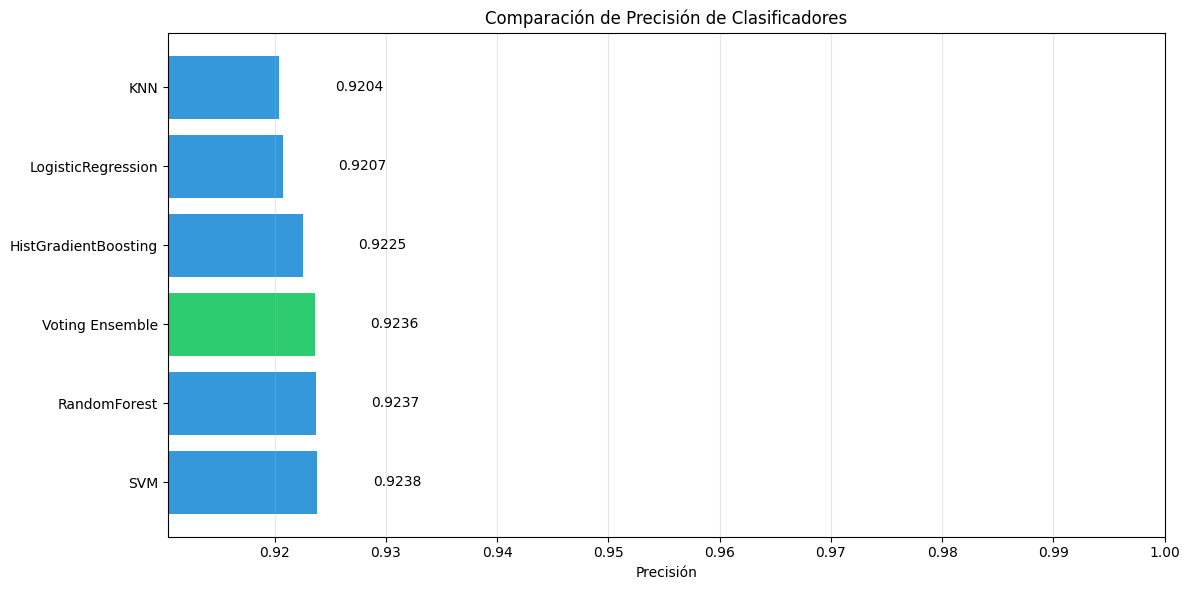

In [ ]:
# ==========================================
# EXTRACCIÓN DE CARACTERÍSTICAS (FLATTEN)
# ==========================================
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Crear un modelo "extractor" que termine en la capa 'concatenated'
extractor = tf.keras.Model(
    inputs=multimodal_model.input,
    outputs=multimodal_model.layers[-5].output  # <- 'concatenate' está 5 capas antes del output
)

# 2. Función para extraer características de un dataset de tf.data
def extract_features_from_dataset(dataset, extractor):
    """
    Extrae características de un tf.data.Dataset usando el modelo extractor
    """
    features_list = []
    labels_list = []

    for batch_inputs, batch_labels in dataset:
        # batch_inputs es una tupla: (image_2d, image_tl, image_1d)
        batch_features = extractor.predict_on_batch(batch_inputs)
        features_list.append(batch_features)

        # Convertir one-hot a etiquetas numéricas
        batch_labels_numeric = np.argmax(batch_labels.numpy(), axis=1)
        labels_list.append(batch_labels_numeric)

    # Concatenar todos los batches
    all_features = np.concatenate(features_list, axis=0)
    all_labels = np.concatenate(labels_list, axis=0)

    return all_features, all_labels

# 3. Extraer características de los datasets
print("Extrayendo características del modelo entrenado...")
print("- Procesando conjunto de entrenamiento...")
X_train_features, y_train_labels = extract_features_from_dataset(train_dataset_combined, extractor)

print("- Procesando conjunto de prueba...")
X_test_features, y_test_labels = extract_features_from_dataset(test_dataset_combined, extractor)

print(f"\nVector de características extraído (train): {X_train_features.shape}")
print(f"Vector de características extraído (test): {X_test_features.shape}")
print(f"Etiquetas de entrenamiento: {y_train_labels.shape}")
print(f"Etiquetas de prueba: {y_test_labels.shape}")

# ==========================================
# ENTRENAR CLASIFICADORES DE MACHINE LEARNING
# ==========================================

# Definir clasificadores (optimizados para velocidad)
clf_svm = SVC(probability=True, kernel='rbf', C=3, gamma='scale', random_state=42)
clf_rf  = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
clf_lr  = LogisticRegression(max_iter=2000, solver='lbfgs', random_state=42)
clf_knn = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)

# HistGradientBoosting: versión moderna y optimizada (mucho más rápida)
clf_gb  = HistGradientBoostingClassifier(
    max_iter=100,           # Número de árboles
    learning_rate=0.1,
    max_depth=None,         # Sin límite (pero se controla con max_leaf_nodes)
    random_state=42,
    verbose=1               # Para ver el progreso
)

# Entrenar cada modelo
modelos = {
    "SVM": clf_svm,
    "RandomForest": clf_rf,
    "LogisticRegression": clf_lr,
    "KNN": clf_knn,
    "HistGradientBoosting": clf_gb
}

print("\n" + "="*60)
print("ENTRENANDO CLASIFICADORES INDIVIDUALES")
print("="*60)

resultados = {}
for nombre, modelo in modelos.items():
    print(f"\nEntrenando {nombre}...")
    modelo.fit(X_train_features, y_train_labels)
    y_pred = modelo.predict(X_test_features)
    acc = accuracy_score(y_test_labels, y_pred)
    resultados[nombre] = acc
    print(f"{nombre:20s} -> Precisión: {acc:.4f}")

# ==========================================
# ENSAMBLE POR VOTACIÓN
# ==========================================

print("\n" + "="*60)
print("ENTRENANDO ENSAMBLE POR VOTACIÓN (SOFT VOTING)")
print("="*60)

voting_clf = VotingClassifier(
    estimators=[
        ('svm', clf_svm),
        ('rf', clf_rf),
        ('lr', clf_lr),
        ('knn', clf_knn),
        ('gb', clf_gb)
    ],
    voting='soft',  # combina probabilidades (más robusto que 'hard')
    n_jobs=-1
)

voting_clf.fit(X_train_features, y_train_labels)
y_pred_voting = voting_clf.predict(X_test_features)
acc_voting = accuracy_score(y_test_labels, y_pred_voting)

print(f"\n✓ Precisión del modelo por votación: {acc_voting:.4f}")

# ==========================================
# COMPARACIÓN DE RESULTADOS
# ==========================================

print("\n" + "="*60)
print("COMPARACIÓN DE TODOS LOS MODELOS")
print("="*60)

# Agregar resultado del ensamble
resultados["Voting Ensemble"] = acc_voting

# Ordenar por precisión
resultados_ordenados = sorted(resultados.items(), key=lambda x: x[1], reverse=True)

print("\nRanking de modelos:")
for i, (nombre, acc) in enumerate(resultados_ordenados, 1):
    print(f"{i}. {nombre:20s} -> Precisión: {acc:.4f}")

# ==========================================
# REPORTES Y MATRIZ DE CONFUSIÓN
# ==========================================

print("\n" + "="*60)
print("REPORTE DETALLADO DEL ENSAMBLE")
print("="*60)

print("\n--- Classification Report ---")
print(classification_report(y_test_labels, y_pred_voting,
                          target_names=[f'Clase {i}' for i in range(10)]))

print("\n--- Matriz de Confusión ---")
cm = confusion_matrix(y_test_labels, y_pred_voting)
print(cm)

# ==========================================
# VISUALIZACIÓN DE LA MATRIZ DE CONFUSIÓN
# ==========================================


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Matriz de Confusión - Ensamble por Votación')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.show()

# ==========================================
# COMPARACIÓN VISUAL DE PRECISIONES
# ==========================================

plt.figure(figsize=(12, 6))
nombres = [nombre for nombre, _ in resultados_ordenados]
precisiones = [acc for _, acc in resultados_ordenados]

colores = ['#2ecc71' if nombre == 'Voting Ensemble' else '#3498db' for nombre in nombres]

plt.barh(nombres, precisiones, color=colores)
plt.xlabel('Precisión')
plt.title('Comparación de Precisión de Clasificadores')
plt.xlim([min(precisiones) - 0.01, 1.0])

for i, (nombre, acc) in enumerate(resultados_ordenados):
    plt.text(acc + 0.005, i, f'{acc:.4f}', va='center')

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()